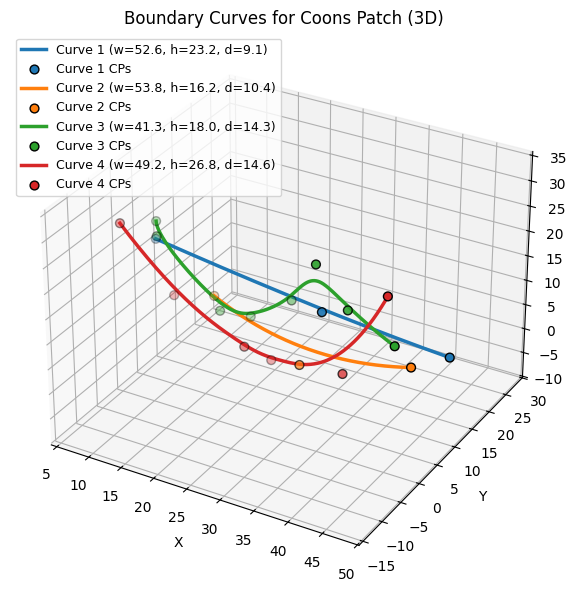

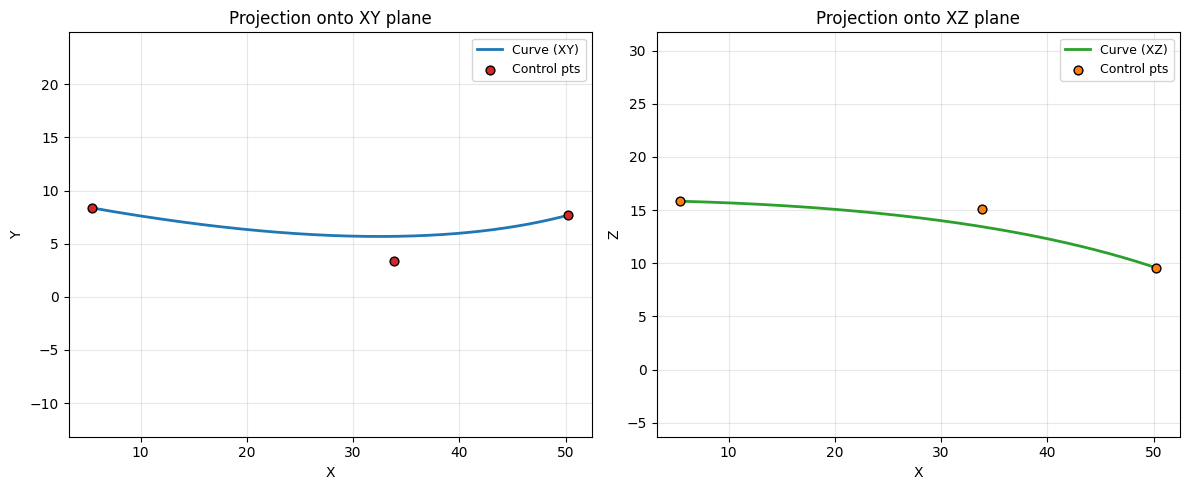

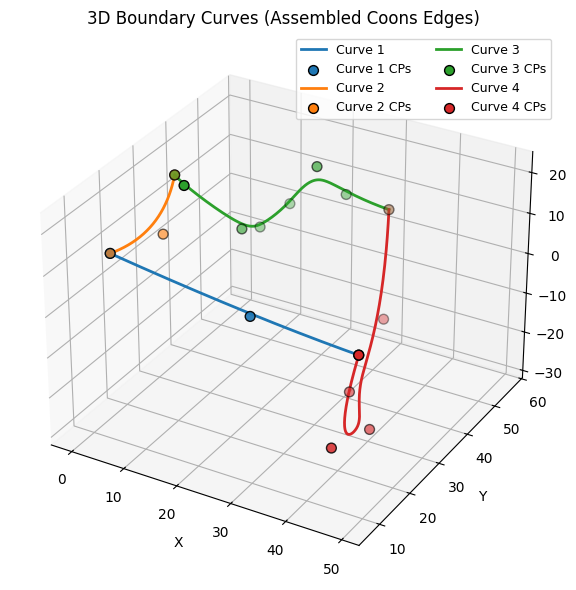

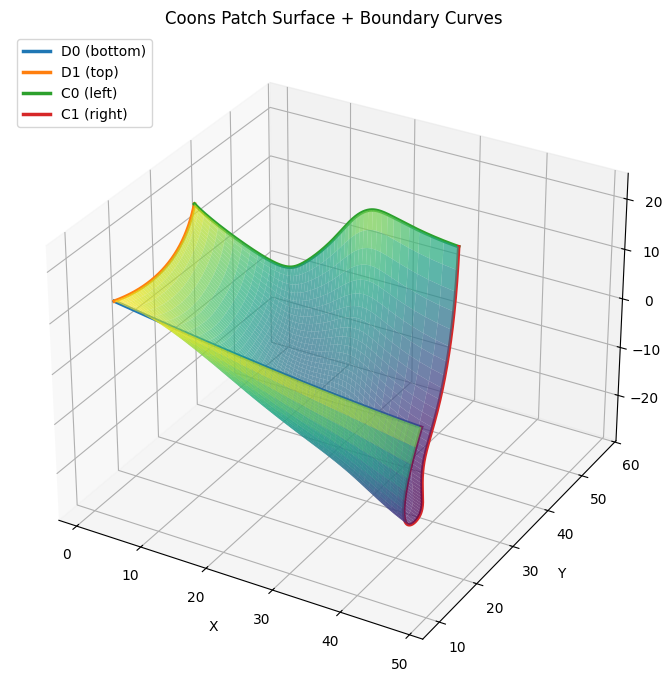

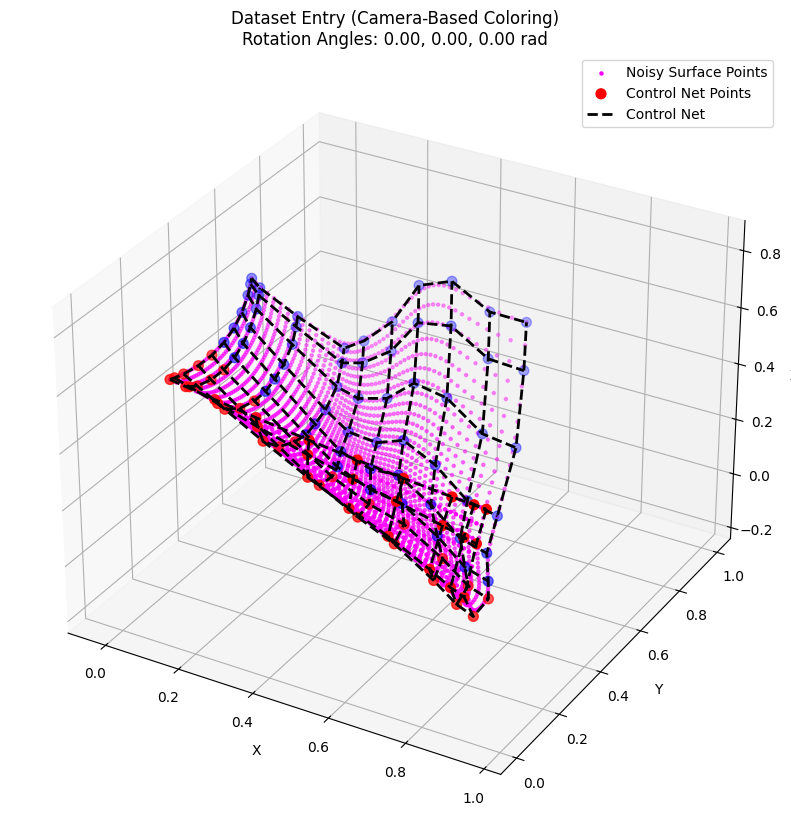

Created a dataset entry.
Rotation angles (radians): (0.0, 0.0, 0.0)
Z-gap between curves: None


In [3]:
import numpy as np
import DatasetGeneratorKoons  # assuming your module is named DatasetGenerator.py



angle_ranges_deg = {
            'x': (-45, 45),
            'y': (45, 45),
            'z': (-45, 45)
        }


angle_ranges_deg = {
            'x': (-45, 45),
            'y': (-45, 45),
            'z': (-10, 10)
        }




# Create a single dataset entry using the new parameter list:
entry = DatasetGeneratorKoons.create_dataset_entry(
    # -------------- curve layout ---------------------------------
    num_points_range      =(3, 8),     # control-points per edge curve
    plane_width_range     =(30, 60),
    plane_height_range    =(15, 30),
    plane_depth_range     =(5, 15), # 5 15

    # -------------- surface-grid resolution ----------------------
    num_samples           = 50,         # points in u-direction (≈ “width”)
    num_v                 = 50,         # points in v-direction (≈ “height”)

    # -------------- NURBS fitting --------------------------------
    degree_u              = 3,
    degree_v              = 3,
    ctrlpts_size_u_range  =(6, 12),
    ctrlpts_size_v_range  =(6, 12),

    # -------------- augmentation ---------------------------------
    noise_std             = 0.0,
    noise_mean            = 0.0,
    random_rotation       = False,
    
    angle_ranges_deg = angle_ranges_deg,


    # -------------- normalise / resample for NN ------------------
    normalize             = True,       # scale to unit box
    resample              = False,      # keep the 35×35 grid as-is
    target_shape          =(50, 50, 3), # ignored if resample=False

    # -------------- visualisation --------------------------------
    show_visu             = True
)

print("Created a dataset entry.")
print("Rotation angles (radians):", entry["rotation_angle"])
print("Z-gap between curves:", entry["z_gap"])






In [1]:
index = 1

import os, pickle


if False:
        filename = f"coons_data_{index}.pkl"
        save_dir = f"dataset_coons"
        file_path = os.path.join(save_dir, filename)
        with open(file_path, "wb") as f:
            pickle.dump(entry, f)
        print(f"coons_data_{index}.pkl")

2025-11-13 02:14:10.143627: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-13 02:14:10.161573: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762996450.182814 3493768 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762996450.189077 3493768 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1762996450.205260 3493768 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

[[[[-0.00597205  0.07215812  0.25263715]
   [ 0.00496938  0.07296273  0.24702288]
   [ 0.02061337  0.0627715   0.25849256]
   ...
   [ 0.789256    0.00756378  0.39799443]
   [ 0.8189196  -0.0054539   0.40305862]
   [ 0.8341424  -0.00359111  0.40594366]]

  [[ 0.0068831   0.0652585   0.25151983]
   [ 0.02629769  0.07387426  0.25961852]
   [ 0.02615091  0.07597139  0.25152856]
   ...
   [ 0.79857874  0.02354447  0.39917788]
   [ 0.820161    0.02554901  0.41378593]
   [ 0.84217465  0.0228817   0.40108702]]

  [[ 0.00861036  0.07598956  0.2471203 ]
   [ 0.02466878  0.08845003  0.23585877]
   [ 0.02441538  0.07154513  0.2442751 ]
   ...
   [ 0.7906272   0.05379792  0.39291298]
   [ 0.81393254  0.05216276  0.3973984 ]
   [ 0.83079296  0.04868994  0.4042385 ]]

  ...

  [[ 0.11625997  0.6280972   0.11300181]
   [ 0.13054313  0.63052493  0.10298436]
   [ 0.13189276  0.62690216  0.06827223]
   ...
   [ 0.6903804   0.95878583  0.2502006 ]
   [ 0.6992587   0.9603367   0.2562692 ]
   [ 0.7137629  

I0000 00:00:1762996455.834672 3494045 cuda_dnn.cc:529] Loaded cuDNN version 90501


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted control net shape: (10, 7, 3)
 control net shape: (10, 7, 3)


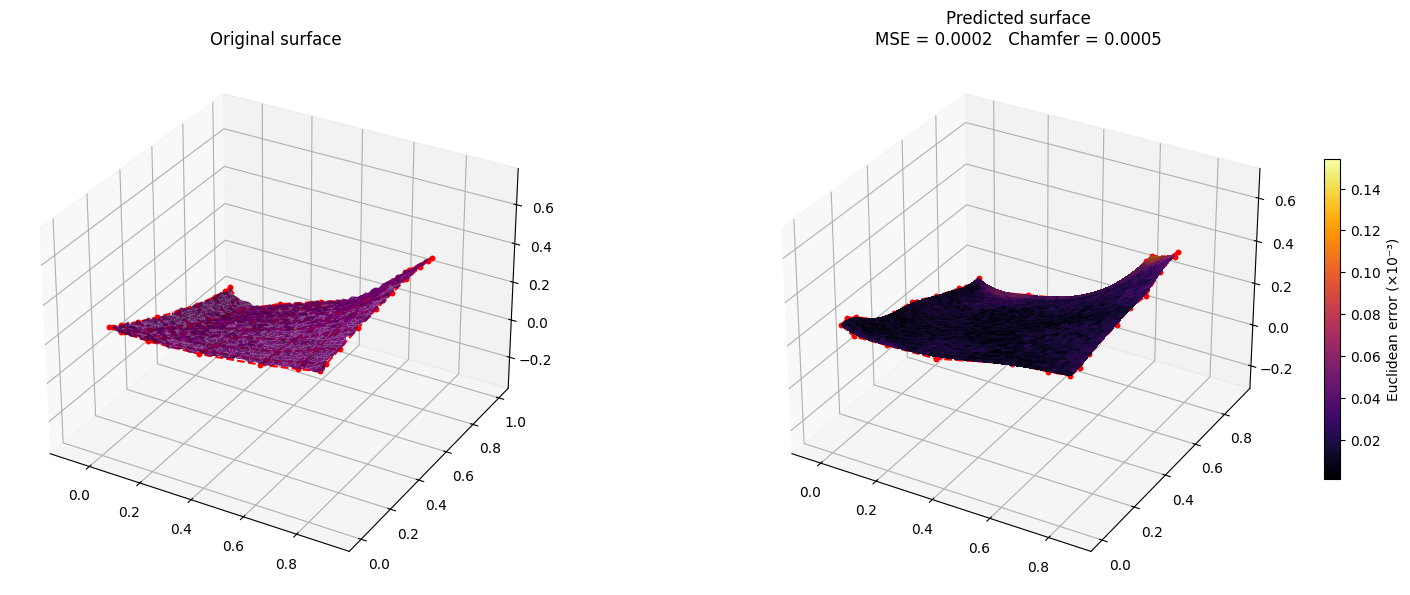

|   mse_surface |   chamfer_surface |   mse_ctrl_net |   chamfer_ctrl_net |
|--------------:|------------------:|---------------:|-------------------:|
|      0.000167 |          0.000465 |       0.000442 |           0.001555 |


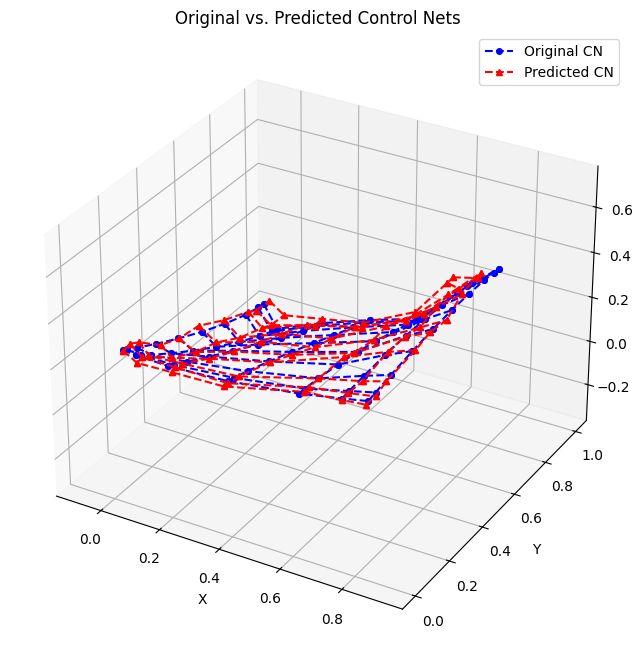

Control‑net shapes (u×v): orig=(10, 7), pred=(10, 7), approx=(10, 7)
MSE  – Predicted vs Original    : 0.000442
MSE  – Approximated vs Original : 0.000055
Chamfer – Predicted vs Original    : 0.001555
Chamfer – Approximated vs Original : 0.000332


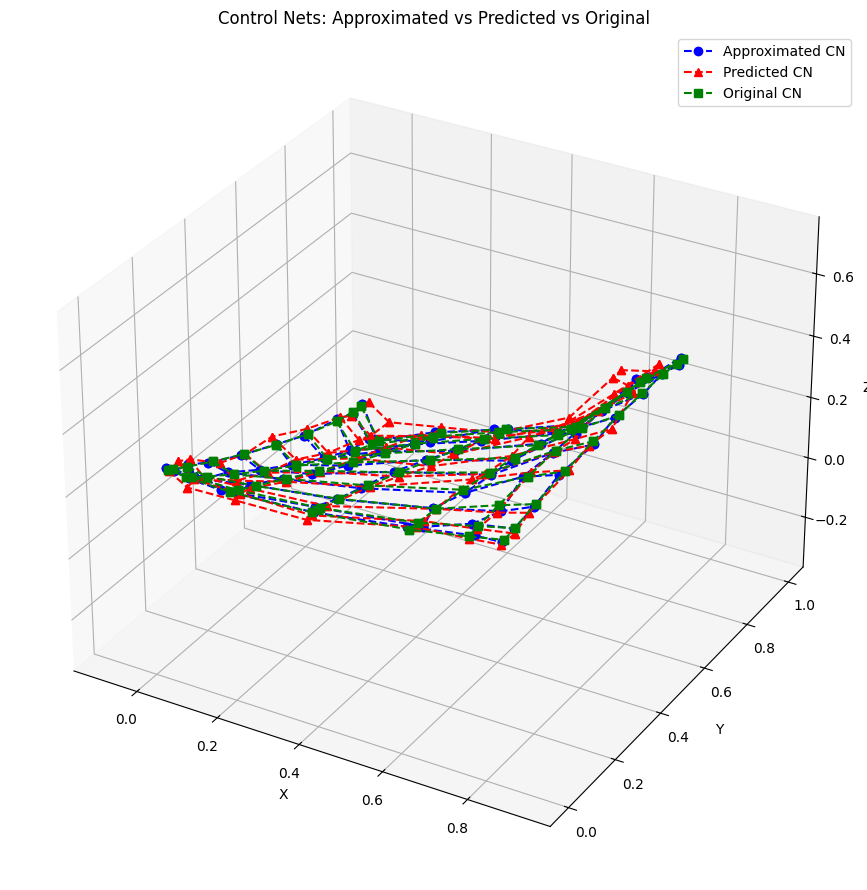

{'mse_predicted': 0.00044179329415783286,
 'mse_approx': 5.5315393855319155e-05,
 'chamfer_predicted': 0.0015550446056209776,
 'chamfer_approx': 0.00033180291606104356}

In [2]:

import DatasetGeneratorKoons  # assuming your module is named DatasetGenerator.py

from tensorflow.keras.utils import register_keras_serializable


def laplacian(grid):
    """
    grid : (B, H, W, C) tensor – C = 3 for (x,y,z)
    returns channel-wise 4-neighbour Laplacian with SAME shape.
    """
    lap_k = tf.constant([[0, 1, 0],
                         [1, -4, 1],
                         [0, 1, 0]], tf.float32)  # (3,3)
    lap_k = lap_k[..., tf.newaxis, tf.newaxis]  # (3,3,1,1)

    C = tf.shape(grid)[-1]  # channel count at run-time
    lap_k = tf.tile(lap_k, [1, 1, C, 1])  # (3,3,C,1)

    return tf.nn.depthwise_conv2d(grid, lap_k,
                                  strides=[1, 1, 1, 1],
                                  padding='SAME')  # (B,H,W,C)


# ─────────────────────────────────────────────────────────────────────

@register_keras_serializable(package='CustomLosses', name='total_loss')
def total_loss(y_true, y_pred, w_lap=0.05):
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    lap = tf.reduce_mean(tf.square(laplacian(y_true) - laplacian(y_pred)))
    return mse + w_lap * lap














dataset_file = f"/home/ainsworth/master/dataset_coons/coons_data_{index}.pkl"



import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
# Import necessary packages and the compare library
import pickle
import numpy as np
import matplotlib.pyplot as plt
import surface_compare_coons
import surface_compare

import tensorflow as tf

# Load a sample dataset entry (assumed to be saved as a pickle file)
# Replace 'sample_entry.pkl' with your actual dataset entry file path.

# Import the non-visualization and visualization libraries
import DatasetGenerator
import nurbs_vis
import pickle
import pandas as pd


# Load the dataset from file.
if True:
    with open(dataset_file, "rb") as f:
        entry = pickle.load(f)

# Visualize the first dataset entry from the loaded dataset.
#nurbs_vis.visualize_dataset_entry(entry[49])

#  models/coons_surface_incept_20251006_0334_30ep.keras

# Load the trained model from the provided file

model = tf.keras.models.load_model("models/coons_surface_incept_20250906_1951_150ep.keras",
                   custom_objects={'total_loss': total_loss})

#model = tf.keras.models.load_model("models/coons_surface_incept_20251103_1858_35ep.keras",
#                   custom_objects={'total_loss': total_loss})


#model = tf.keras.models.load_model("models/incept_surface_0904_0626_200ep_1.9432.keras")

#model = tf.keras.models.load_model("models/incept_surface_0704_1040_200ep_1.1381.keras")
#model.summary()

# Create a dummy input sample matching the model's expected input shape (1, 100, 100, 3).
# Replace this with your actual test image or data sample.
#test_entry = entry["data"][9]
test_entry = entry

test_entry["points"], _ = surface_compare.add_noise(test_entry["points"], "gaussian", 0.005)


dummy_input =   DatasetGeneratorKoons.prepare_input_for_model(test_entry, target_shape=(50, 50, 3))


print(dummy_input)

# Use the model to predict the control net.
predicted_ctrl_net = model.predict(dummy_input)

predicted_ctrl_net = surface_compare_coons.remove_padding_and_shrink_control_net(predicted_ctrl_net, threshold=0.5, padding_value=-0.1, padding_tol=0.31)

# Display the shape and a snippet of the predicted control net.
print("Predicted control net shape:", predicted_ctrl_net.shape)
print(" control net shape:", test_entry["control_net"].shape)
#print("Predicted control net values (snippet):\n", predicted_ctrl_net[0])

metrics = surface_compare_coons.compare_surfaces(test_entry, predicted_ctrl_net, num_samples=50, show_control_net=True)

# Convert to a structured DataFrame
df_metrics = pd.DataFrame([metrics])

# Display in an interactive table
print(df_metrics.to_markdown(index=False, floatfmt=".6f"))

#surface_compare_coons.compare_control_nets_in_one_plot(test_entry["control_net"] , predicted_ctrl_net)

surface_compare_coons.compare_control_nets_in_one_plot(
    original=test_entry,
    predicted_cn=predicted_ctrl_net,
)
surface_compare_coons.compare_approximated_control_nets(
    original_entry=test_entry,
    predicted_ctrl_net= predicted_ctrl_net,
    degree_u=3,       # Adjust as in your data generation settings
    degree_v=3    # ctrlpts_size_u and ctrlpts_size_v are automatically derived from predicted_ctrl_net's shape (e.g., 4, 7)
)

